# Dask Array

Материалы:
* Макрушин С.В. Лекция 11: Dask
* https://docs.dask.org/en/latest/array.html
* JESSE C. DANIEL. Data Science with Python and Dask.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Задачи для совместного разбора

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива.

In [ ]:
import dask.array as da
import h5py
import numpy as np

In [ ]:
norm1  = da.random.normal(size=(1000, 300000))
norm1

dask.array<normal, shape=(1000, 300000), dtype=float64, chunksize=(1000, 16777), chunktype=numpy.ndarray>

2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

In [ ]:
norm2 = np.random.normal(size=(1000, 300000))
print(norm2)

[[ 0.23511093  0.5849319   0.2954271  ... -0.18806501  1.02446709
   1.23466187]
 [ 0.14729528 -1.32237228 -0.98268505 ...  0.10737757  0.75293663
  -0.70664814]
 [-1.84009716 -0.45152449  1.46434659 ... -0.35799176  0.55534409
   0.62159578]
 ...
 [-0.73660925 -0.60703881  1.29251452 ...  0.80610241  0.45905994
   0.17923066]
 [ 1.29920726  0.28068869 -0.20515632 ...  0.85659266 -0.04810777
  -0.51669839]
 [ 0.1209065  -0.02138048  0.75295974 ...  1.9080924  -0.23838766
   1.01273692]]


In [ ]:
%%time
norm1_sum = da.square(norm1).sum()
print(norm1_sum.compute())

300005358.97380733
CPU times: user 15.5 s, sys: 1.66 s, total: 17.2 s
Wall time: 13.3 s


In [ ]:
%%time
norm2_sum = np.square(norm2).sum()
print(norm2_sum)

300005569.69257396
CPU times: user 648 ms, sys: 2.07 s, total: 2.71 s
Wall time: 2.75 s


3. Визуализируйте граф вычислений для задачи 12.

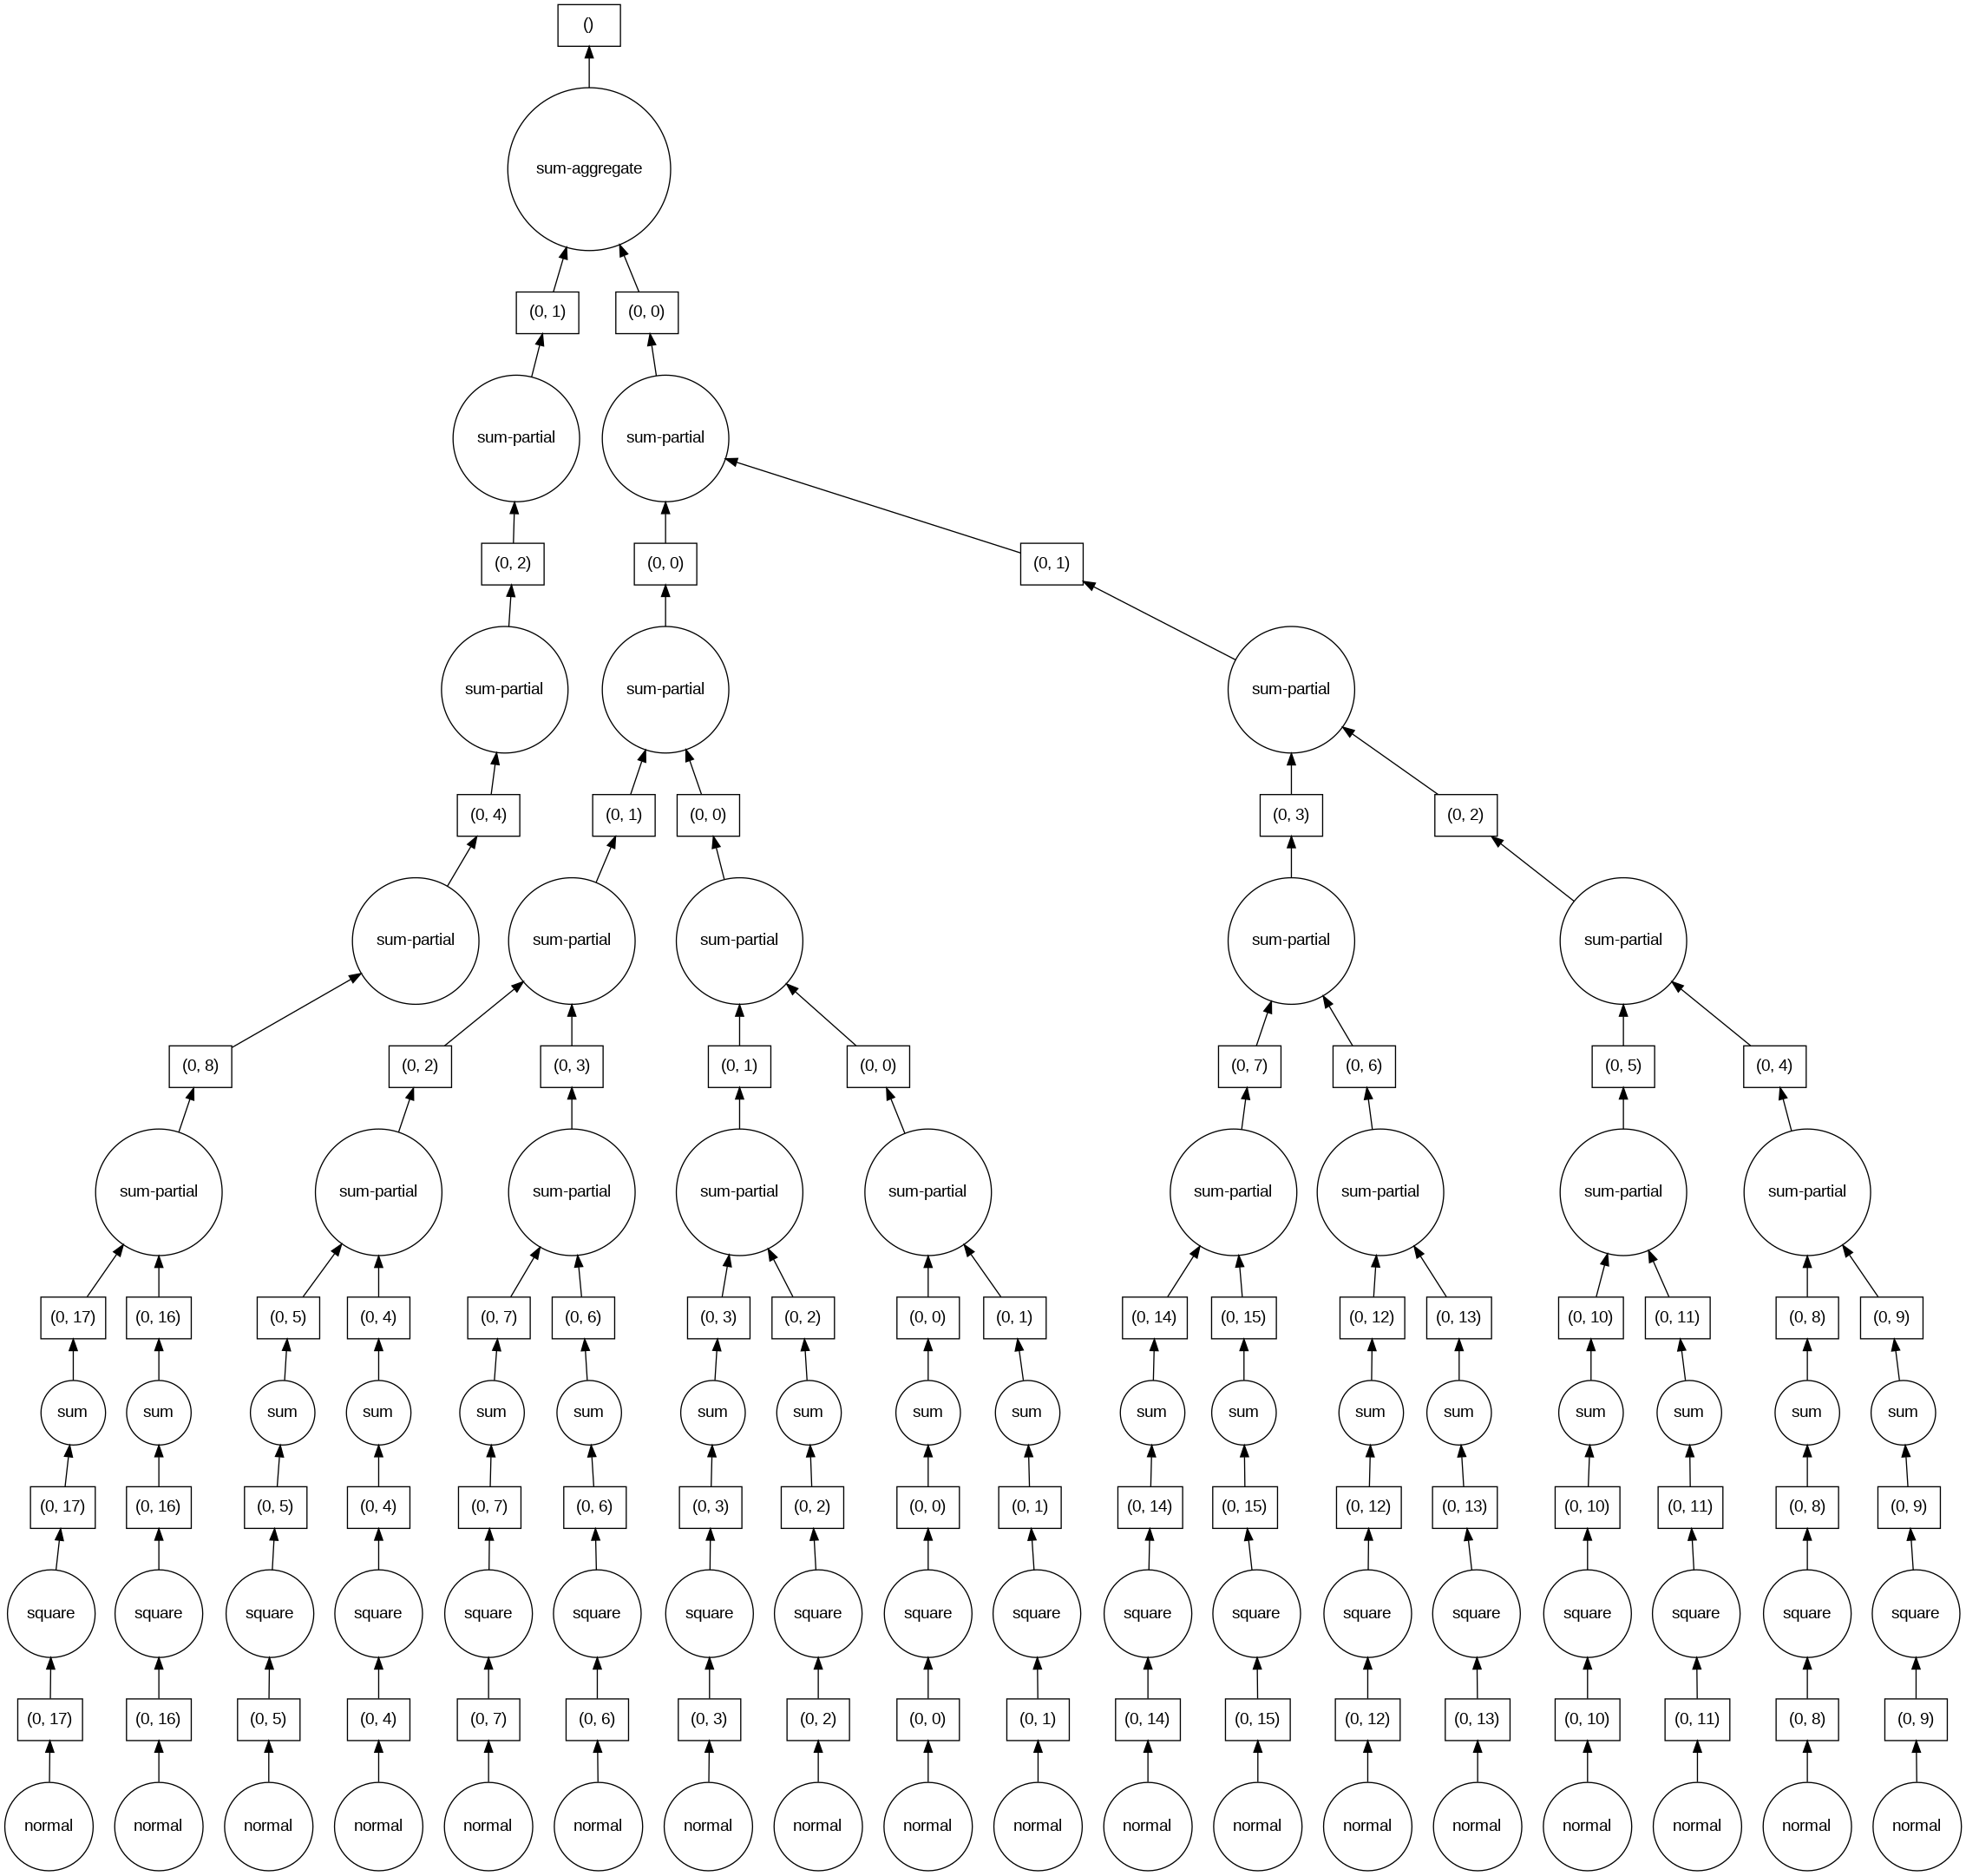

In [ ]:
norm1_sum.visualize()

## Лабораторная работа 11

1. Считайте датасет `recipe` из файла `minutes_n_ingredients_full.hdf5` в виде `dask.array`. Укажите аргумент `chunks=(100_000, 3)` при создании массива. Выведите на экран основную информацию о массиве.

In [ ]:
df = h5py.File('/content/drive/MyDrive/minutes_n_ingredients_full.hdf5','r')
recipe = df['recipe']
recipe.shape

(2231637, 3)

In [ ]:
data = da.from_array(recipe,chunks=(100_000, 3))
data

dask.array<array, shape=(2231637, 3), dtype=int64, chunksize=(100000, 3), chunktype=numpy.ndarray>

2. Вычислите среднее значение по каждому столбцу, кроме первого.

In [ ]:
%%time
avg = da.mean(data[::,1:], axis = 0)
avg.compute()

CPU times: user 193 ms, sys: 31.9 ms, total: 225 ms
Wall time: 899 ms


array([1004.20805176,    5.4198008 ])

3. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего.

In [ ]:
data2 = da.from_array(recipe,chunks=(100, 3))
data2

dask.array<array, shape=(2231637, 3), dtype=int64, chunksize=(100, 3), chunktype=numpy.ndarray>

In [ ]:
%%time
avg = da.mean(data2[::,1:], axis = 0)
avg.compute()

CPU times: user 20 s, sys: 2.02 s, total: 22 s
Wall time: 23.3 s


array([1004.20805176,    5.4198008 ])

In [ ]:
data3 = da.from_array(recipe,chunks=(100000000, 3))
data3

dask.array<array, shape=(2231637, 3), dtype=int64, chunksize=(2231637, 3), chunktype=numpy.ndarray>

In [ ]:
%%time
avg = da.mean(data3[::,1:], axis = 0)
avg.compute()

CPU times: user 105 ms, sys: 24.8 ms, total: 130 ms
Wall time: 128 ms


array([1004.20805176,    5.4198008 ])

In [ ]:
data4 = np.array(recipe)

In [ ]:
%%time
avg = np.mean(data4[::,1:], axis = 0)
avg

CPU times: user 66.7 ms, sys: 0 ns, total: 66.7 ms
Wall time: 68.4 ms


array([1004.20805176,    5.4198008 ])

4. Выберите рецепты, время выполнения которых меньше медианного значения

In [ ]:
avg_minutes = da.mean(data[::,0], axis = 0)
avg_minutes.compute()

1126840.889062603

In [ ]:
x = data[::,0] < avg_minutes
data_new = data[data[::,0] < avg_minutes].compute()
data_new

array([[ 683970,      33,       9],
       [1089012,      23,       5],
       [ 387709,      47,      10],
       ...,
       [1029131,      19,       4],
       [ 713836,       0,       9],
       [ 660699,      64,       8]])

In [ ]:
data_new.shape[0]

1126841

5. Посчитайте количество каждого из возможных значений кол-ва ингредиентов

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data, columns=["minutes", "n","full"])
df.groupby(['n']).count()["full"]

n
0             31645
1             31406
2             32740
3             32155
4             31558
              ...  
259205            1
259260            1
288000            1
1051200           1
2147483647        1
Name: full, Length: 888, dtype: int64

6. Найдите максимальную продолжительность рецепта. Ограничьте максимальную продолжительность рецептов сверху значением, равному 75% квантилю.

In [ ]:
max = data[::,0].max()
max.compute()

2231636

In [ ]:
data5 = data
data5[::,0] = da.where(data5[::,0]<np.quantile(data5[::,0], 0.75),data5[::,0],np.quantile(data5[::,0], 0.75))
max = data5[::,0].max()
max.compute()

/usr/local/lib/python3.9/dist-packages/dask/array/core.py:1712: FutureWarning: The `numpy.quantile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/dask/array/core.py:1712: FutureWarning: The `numpy.quantile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


1673727

7. Создайте массив `dask.array` из 2 чисел, содержащих ваши предпочтения относительно времени выполнения рецепта и кол-ва ингредиентов. Найдите наиболее похожий (в смысле $L_1$) рецепт из имеющихся в датасете.

In [ ]:
input_recipe = [10, 10]
input_recipe = da.from_array(input_recipe)

def l1_distance(block):
  print(block)
  return da.abs(block[:, :2] - input_recipe).sum(axis=1)

distances = l1_distance(data)
index = distances.argmin()
print(index.compute())

recipe_id = data[index, 0].compute()

print(f"Самое близкое по параметрам {input_recipe.compute()} - id {recipe_id}.")

dask.array<setitem, shape=(2231637, 3), dtype=int64, chunksize=(100000, 3), chunktype=numpy.ndarray>
1112421
Самое близкое по параметрам [10 10] - id 52.


8. Работая с исходным файлом в формате `hdf5`, реализуйте алгоритм подсчета среднего значения в блочной форме и вычислите с его помощью среднее значение второго столбца в массиве.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных по `blocksize` элементов и проведение вычислений на этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5py` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент

In [ ]:
ffile = h5py.File('/content/drive/MyDrive/minutes_n_ingredients_full.hdf5')

class BlocksCounter:
  def init(self, dataset : h5py._hl.dataset.Dataset, blocksize : int, column : int) -> None:
    self.dataset = dataset
    self.blocksize = blocksize
    self.column = column
    self.blocks_list = []

  self._result = None

  self.processing()

  def processing(self) -> None:
    self.first_step()
    self.second_step()

  def first_step(self) -> None:
    dataset_len = self.dataset.shape[0]

    for i in range(0, dataset_len + 1, self.blocksize):

      if (i + self.blocksize <= dataset_len + 1):
        stop = i + self.blocksize
      else:
        stop = dataset_len + 1

block_result = (self.dataset[i:stop, self.column].sum(), stop - i)
self.blocks_list.append(block_result)

def second_step(self) -> None:

dataset_len = self.dataset.shape[0]
items_list = []

for block in self.blocks_list:
items_list.append(block[0])

self._result = sum(items_list) / dataset_len

@property
def result(self) -> float:
if self._result is None:
raise ValueError("Результат еще не был вычислен!")
return self._result

start_time = time.time()
counter = BlocksCounter(dataset=ffile['recipe'], blocksize=100_000, column=1)
print(f"-— {time.time() - start_time} сек —-")
counter.result

recipes = da.from_array(ffile['recipe'], chunks=(100_000, 3))

start_time = time.time()
result = recipes[:, 1].mean().compute()
print(f"-— {time.time() - start_time} сек —-")
result